### Import Libraries

In [2]:
import cv2 as cv
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import datasets, layers, models
from tensorflow.keras.utils import image_dataset_from_directory 
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image
import random

### TAHAP PREPROCESSING

#### Resizing and Thresholding

In [3]:
def thresholding(input_folder, output_folder):
    #Samakan ukuran berdasarkan pixel
    new_size = (240, 240)

    # Buat folder baru untuk menyimpan hasil resizing jika belum ada
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Loop melalui semua file dalam folder
    for filename in os.listdir(input_folder):
        if filename.endswith(('.jpg', '.jpeg', '.png')):  # Filter file gambar
            img_path = os.path.join(input_folder, filename)

            img = cv.imread(img_path,0)

            # Resize gambar
            img_resized = cv.resize(img, new_size, interpolation=cv.INTER_LANCZOS4)

            threshold_value = 100
            ret, img_threshold = cv.threshold(img_resized, threshold_value, 255, cv.THRESH_TRUNC)
            #ret menyimpan nilai ambang yang digunakan dalam operasi thresholding = threshold_value = 100

            # Simpan hasil thresholding ke folder output
            output_path = os.path.join(output_folder, filename)
            cv.imwrite(output_path, img_threshold)

    print("Thresholding done!")

thresholding('./data_awal/YES','./dataset/YES_thresholding')
thresholding('./data_awal/NO','./dataset/NO_thresholding')

Thresholding done!
Thresholding done!


#### Edge Detection and Normalization

In [4]:
def edge_detection(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.endswith(('.jpg', '.jpeg', '.png')):  # Filter file gambar
            img_path = os.path.join(input_folder, filename)

            img = cv.imread(img_path)

            #Mengubahnya jadi tipe data floating point (CV_64F) u/ menghindari hilangnya informasi tepi yg negatif
            sobelx_f = cv.Sobel(img,cv.CV_64F,1,0,ksize=3) #Gradien dalam arah x hasil dari operasi Sobel
            sobely_f = cv.Sobel(img,cv.CV_64F,0,1,ksize=3) #Gradien dalam arah y hasil dari operasi Sobel.

            magnitude = cv.magnitude(sobelx_f,sobely_f) #menghitung magnitudo gradien dari hasil deteksi tepi dalam floating point
            #abs_sobel64f = np.absolute(magnitude) #mengonversi nilai absolut magnitudo menjadi tipe data 64-bit floating point
            #sobel_8u = np.uint8(abs_sobel64f) #mengonversi hasil tersebut ke tipe data 8-bit unsigned integer

            #img = sobel_8u

            #Normalisasi gambar
            img_normalized = cv.normalize(magnitude, None, 0, 1, cv.NORM_MINMAX)

            # Simpan hasil thresholding ke folder output
            output_path = os.path.join(output_folder, filename)
            cv.imwrite(output_path, (img_normalized * 255).astype(np.uint8))

    print("Edge detection and Normalization done!")

edge_detection('./dataset/YES_thresholding','./dataset/data/ya')
edge_detection('./dataset/NO_thresholding','./dataset/data/tidak')

Edge detection and Normalization done!
Edge detection and Normalization done!


In [5]:
data = './dataset/data'
kelas = os.listdir(data)
print(kelas)

['tidak', 'ya']


#### Menampilkan beberapa citra beserta labelnya

In [6]:
yes = 'dataset/data/ya'
no = 'dataset/data/tidak'

#### Mengambil images dari folder ya dan tidak untuk diberi label 1 untuk yes, 0 untuk no, dan diletakkan ke dalam list all_images


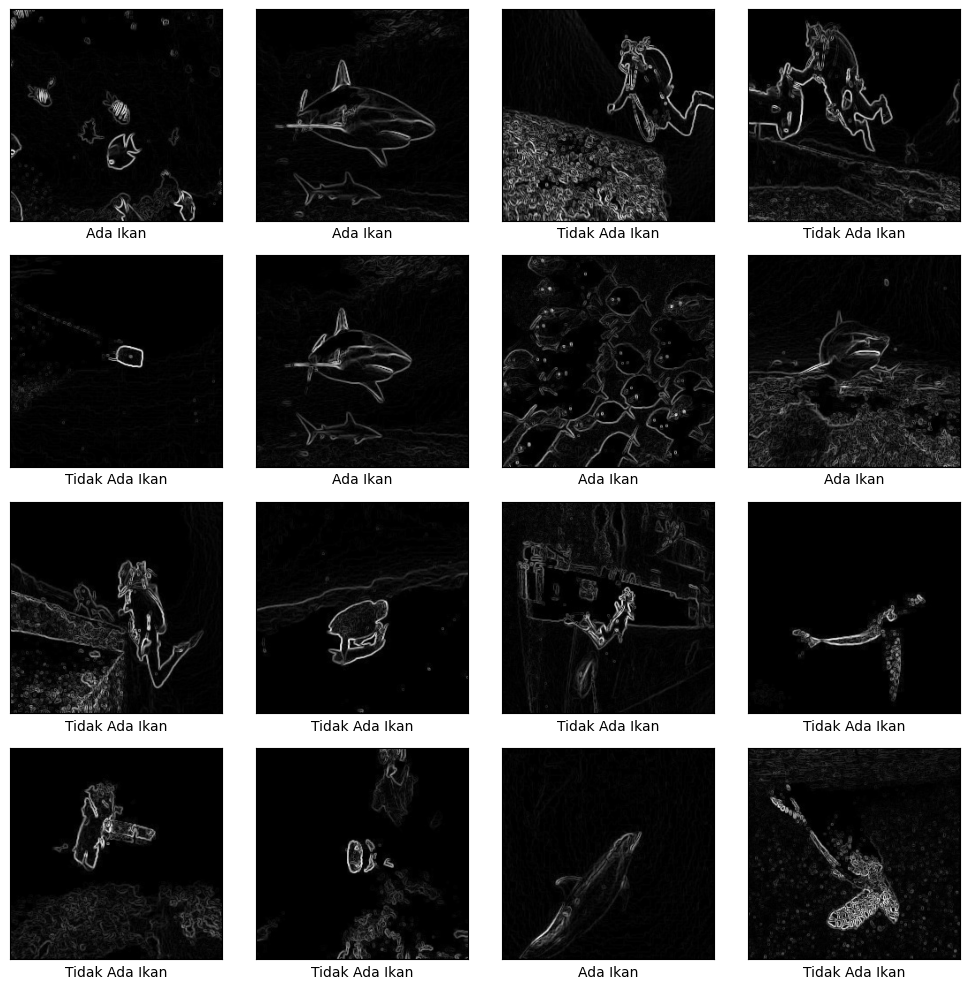

In [7]:
all_images = []

for filename in os.listdir(yes):
    if filename.endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(yes, filename)
        all_images.append((img_path, 1))

for filename in os.listdir(no):
    if filename.endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(no, filename)
        all_images.append((img_path, 0))

random.shuffle(all_images)

plt.figure(figsize=(10, 10))
for i in range(min(16, len(all_images))):
    img_path, label = all_images[i]
    img = cv.imread(img_path)
    plt.subplot(4, 4, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img)
    plt.xlabel('Ada Ikan' if label == 1 else 'Tidak Ada Ikan')

plt.tight_layout()
plt.show()


#### Membagi data menjadi data train dan data test

In [8]:
train_datagen = image_dataset_from_directory(data,
                                             image_size=(240,240),
                                             subset='training',
                                             seed = 1, #untuk konsistensi gambar mana saja yang jadi train dan test (akan selalu sama)
                                             validation_split = 0.2,
                                             batch_size = 32)

test_datagen = image_dataset_from_directory(data,
                                            image_size=(240,240),
                                            subset='validation',
                                            seed = 1, #untuk konsistensi gambar mana saja yang jadi train dan test (akan selalu sama)
                                            validation_split = 0.2,
                                            batch_size = 32)

Found 200 files belonging to 2 classes.
Using 160 files for training.
Found 200 files belonging to 2 classes.
Using 40 files for validation.


#### Membuat Lapisan Konvolusional diikuti MaxPooling untuk mengekstraksi fitur dari citra. Layer Flatten u/ mengubah  output dari layer konvolusi menjadi vektor satu dimensi, dan layer Dense di bagian akhir untuk klasifikasi, dengan fungsi aktivasi ReLU untuk layer tersembunyi dan sigmoid untuk output

In [9]:
img_height, img_width = 240, 240
new_size = (img_width, img_height)

# Definisikan model
model = models.Sequential()
#layer konvolusi pertama dengan 32 jumlah filter, kernel 3x3, fungsi aktivasi 'ReLU setelah operasi konvolusi. Input model 240, 240, 3(gambar channel 3/berwarna)
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(layers.MaxPooling2D((2, 2))) #ukuran jendela pooling 2x2
#layer konvolusi tambahan menggunakan 64, 128 filter dan fungsi aktivitas ReLU
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

#mengubah output layer sebelumnya menjadi vektor satu dimensi agar dapat jadi masukan pada layer Dense (fully connected)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(256, activation='relu'))
#layer output dengan 1 unit (karena klasifikasi biner)
#fungsi sigmoid menghasilkan probabilitas 0 hingga 1
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile( 
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'] 
)


c:\Users\IKA KUSUMA\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 238, 238, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 119, 119, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 117, 117, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 58, 58, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,783,873 (98.36 MB)

 Trainable params: 25,783,873 (98.36 MB)

 Non-trainable params: 0 (0.00 B)

#### Callback untuk menyimpan model terbaik berdasarkan akurasi validasi

In [10]:
checkpoint_callback = ModelCheckpoint(filepath='best_model.keras',
                                      monitor='val_accuracy',
                                      mode='max',
                                      save_best_only=True,
                                      verbose=1)

Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.5301 - loss: 116.8693 
Epoch 1: val_accuracy improved from -inf to 0.57500, saving model to best_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 66s 12s/step - accuracy: 0.5324 - loss: 113.9066 - val_accuracy: 0.5750 - val_loss: 4.6687
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.6614 - loss: 2.0318
Epoch 2: val_accuracy improved from 0.57500 to 0.62500, saving model to best_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 52s 12s/step - accuracy: 0.6574 - loss: 1.9683 - val_accuracy: 0.6250 - val_loss: 0.9704
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7579 - loss: 0.4371
Epoch 3: val_accuracy did not improve from 0.62500
5/5 ━━━━━━━━━━━━━━━━━━━━ 61s 6s/step - accuracy: 0.7649 - loss: 0.4306 - val_accuracy: 0.6000 - val_loss: 0.6697
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9103 - loss: 0.2403 
Epoch 4: val_accuracy improved from 0.62500 to 0.77500, saving model to best_model.keras
5/5 ━━━━━━━━

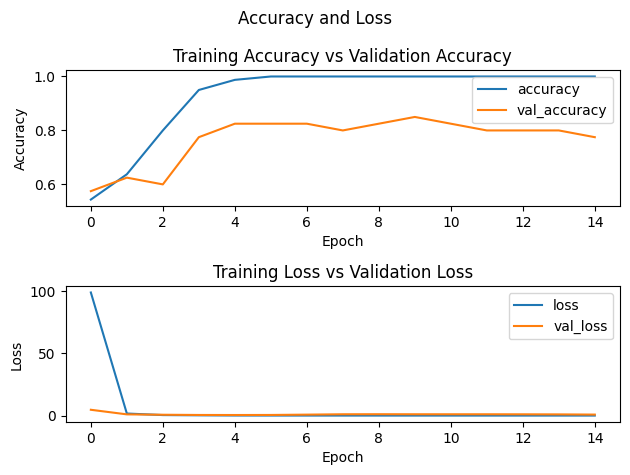

In [11]:
#Pelatihan model
history = model.fit(train_datagen, 
                    epochs=15, 
                    validation_data=test_datagen,
                    callbacks=[checkpoint_callback])

test_loss, test_acc = model.evaluate(test_datagen, verbose=2)
print('Validation loss : ', test_loss)
print('Validation accuracy : ', test_acc)

history_df = pd.DataFrame(history.history) 

# Subplot 2: Plot accuracy dan val_accuracy
plt.subplot(2, 1, 1)
history_df[['accuracy', 'val_accuracy']].plot(ax=plt.gca())
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs Validation Accuracy')

# Subplot 2 : Plot loss dan val_loss
plt.subplot(2, 1, 2)
history_df[['loss', 'val_loss']].plot(ax=plt.gca())
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Validation Loss')

# Menambahkan judul utama
plt.suptitle('Accuracy and Loss')
plt.tight_layout()
plt.show()

In [12]:
best_model = keras.models.load_model('best_model.keras')

### Tahap Processing Klasifikasi dan Prediksi

#### Fungsi preprocessing untuk prediksi

In [13]:
def preprocess_image(input_folder, filename):
    img_path = os.path.join(input_folder, filename)
    
    img = cv.imread(img_path, 0)
    
    #resize image ke piksel 240 x 240
    img_height, img_width = 240, 240
    new_size = (img_width, img_height)
    img_resized = cv.resize(img, new_size, interpolation=cv.INTER_LANCZOS4)

    # Thresholding Trunc
    threshold_value = 100
    ret, img_threshold = cv.threshold(img_resized, threshold_value, 255, cv.THRESH_TRUNC)

    # Sobel u/ mendapatkan gradien dalam arah horizontal dan vertikal untuk mendapatkan gradien dalam arah horizontal dan vertikal
    # Sobel magnitude untuk edge detection
    sobelx_f = cv.Sobel(img_threshold, cv.CV_64F, 1, 0, ksize=3)
    sobely_f = cv.Sobel(img_threshold, cv.CV_64F, 0, 1, ksize=3)
    magnitude = cv.magnitude(sobelx_f, sobely_f)

    # Normalize magnitude jadi rentang [0, 1] atau min = 0 dan max = 1 dengan NORMALISASI MIN MAX dari openCV
    img_normalized = cv.normalize(magnitude, None, 0, 1, cv.NORM_MINMAX)

    # mengubahnya jadi RGB karena dia 3-channel sebab model butuh inputan 3-channel
    img_normalized_rgb = cv.cvtColor((img_normalized * 255).astype(np.uint8), cv.COLOR_GRAY2RGB)

    return img_normalized_rgb

#### Fungsi untuk memampilkan hasil prediksi

In [14]:
def predict_and_plot(files):
    plt.figure(figsize=(20, 20))
    for i, file in enumerate(files):
        input_folder, filename = os.path.split(file) #di-split agar mendapatkan jalur file sehingga didapatkan direktor dan filname
        
        # Tahapan preprocessing (resizing, thresholding, edge detection, normalization)
        img_normalized = preprocess_image(input_folder, filename)
        
        #Memprediksi citra dengan model
        img_for_prediction = np.expand_dims(img_normalized, axis=0)
        predictions = model.predict(img_for_prediction)
        label = 'Ikan' if predictions[0][0] > 0.5 else 'Tidak ada ikan' #jika hasil prediksi >0.5, gambar diprediksi 'Ikan' sebaliknya, 'TIdak Ada Ikan'
        
        plt.subplot(4, 4, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img_normalized)
        plt.xlabel(label)
    
    plt.show()

#### Fungsi mengambil gambar acak dari data awal untuk mengecek hasil prediksi oleh model

In [15]:
def get_random_files(dataset_folder, num_files=16):
    all_files = []
    for label in ['YES', 'NO']:
        folder_path = os.path.join(dataset_folder, label)
        files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        all_files.extend(files)
    
    random_files = random.sample(all_files, num_files)
    return random_files

#### Data yang diprediksi adalah data random berjumlah 16 yang didapatkan dari data awal sebelum di-preprocessing

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


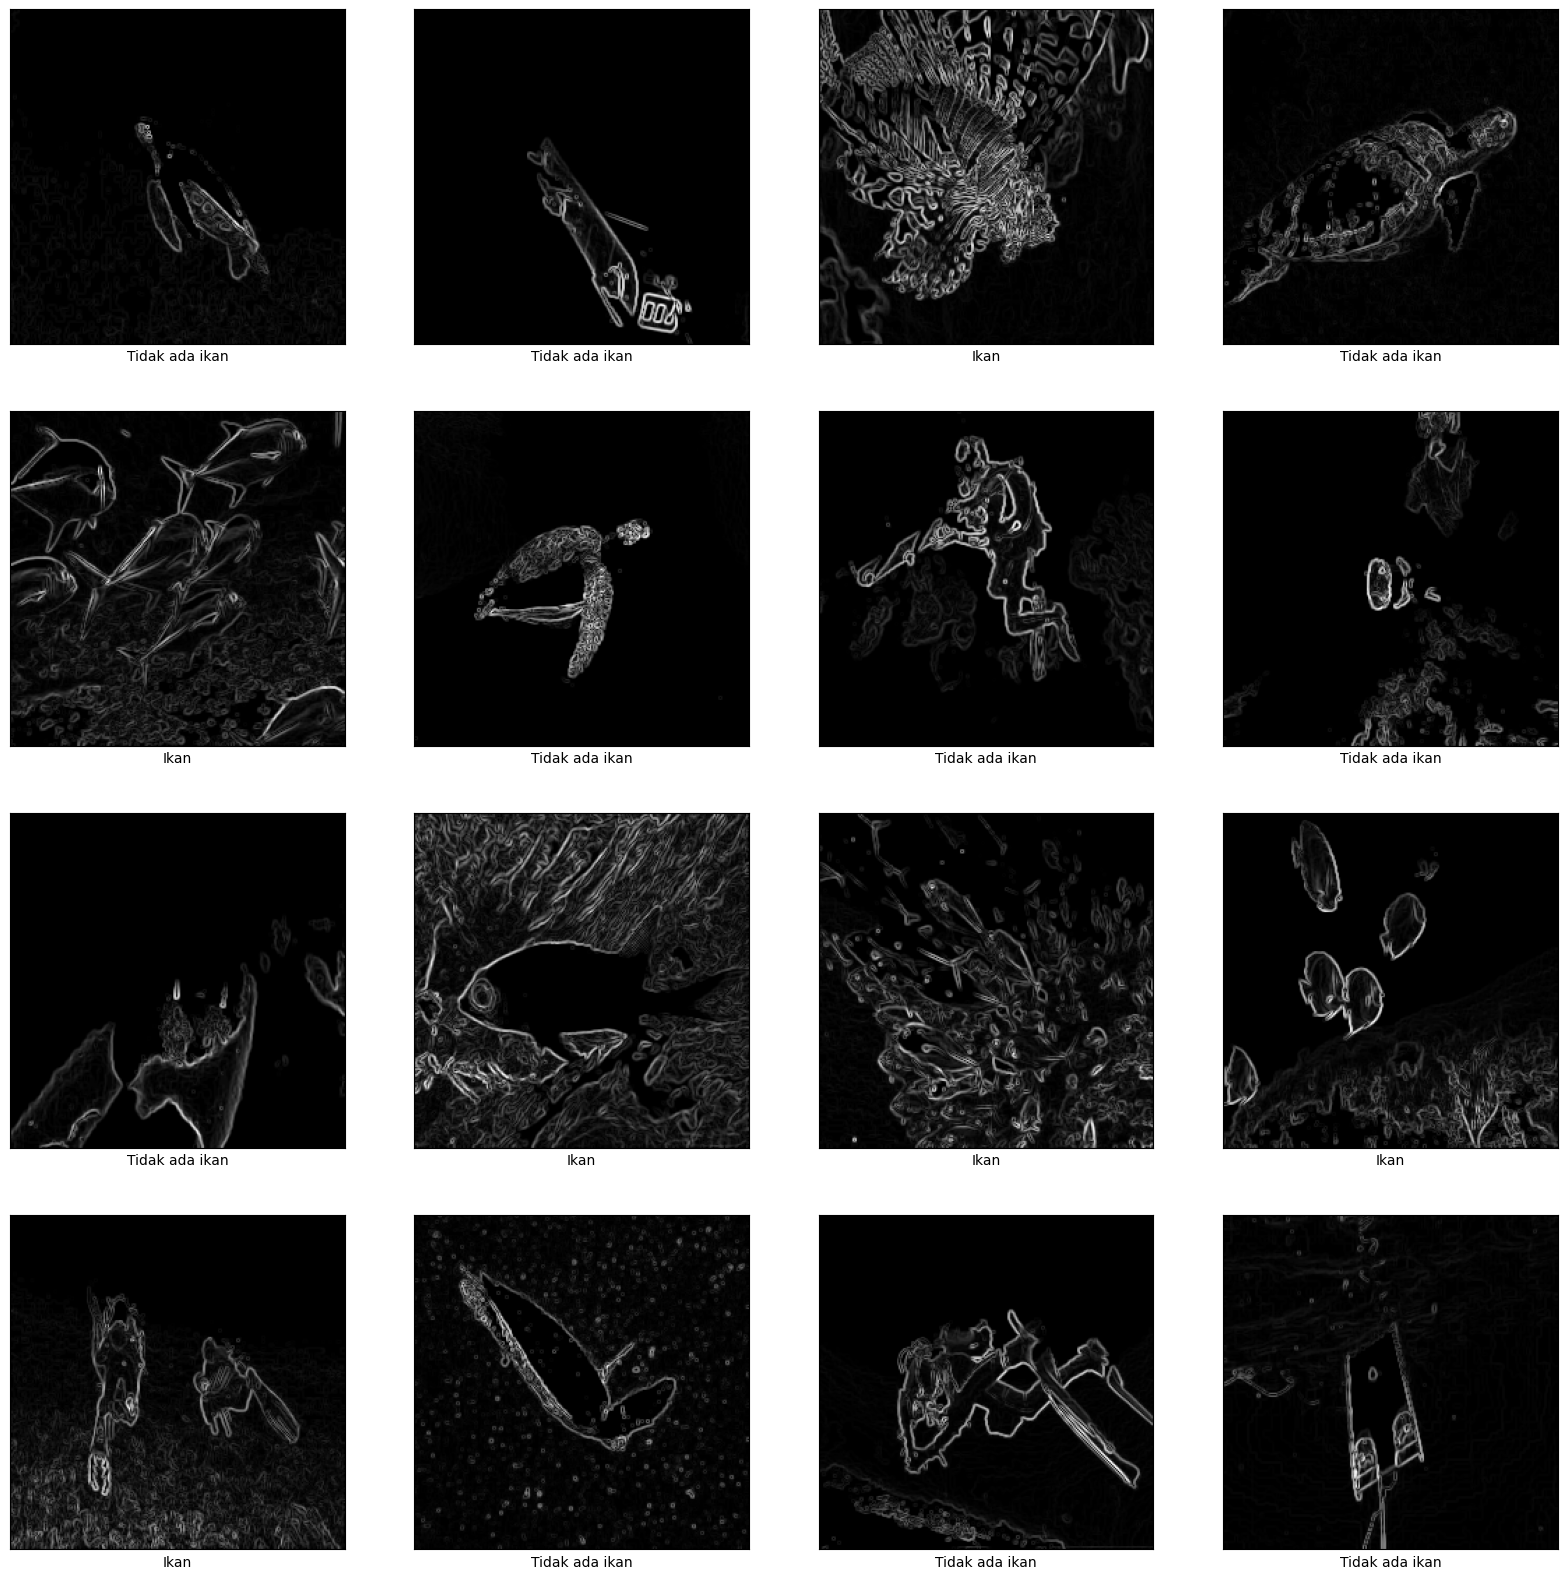

In [16]:
dataset_folder = './data_awal'  
random_files = get_random_files(dataset_folder)
predict_and_plot(random_files)